In [1]:
import os
import pickle
import time
import cv2
import numpy as np
import feature_extraction as fe
import heatmap as hm
import util
import matplotlib.pyplot as plt
%matplotlib inline

### Image Location

In [2]:
car_directories = ['vehicles/GTI_Far/',
                   'vehicles/GTI_Left/',
                   'vehicles/GTI_Right/',
                   'vehicles/GTI_MiddleClose/',
                   'vehicles/KITTI/']
noncar_directories = ['non-vehicles/GTI/', 'non-vehicles/Extras/']

cars = [os.listdir(car_directory) for car_directory in car_directories]
non_vehicles = [os.listdir(noncar_directory) for noncar_directory in noncar_directories]

### Settings

In [3]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
ystart = 400
ystop = 700
img_shape = (720, 1280, 3)

### HOG Features

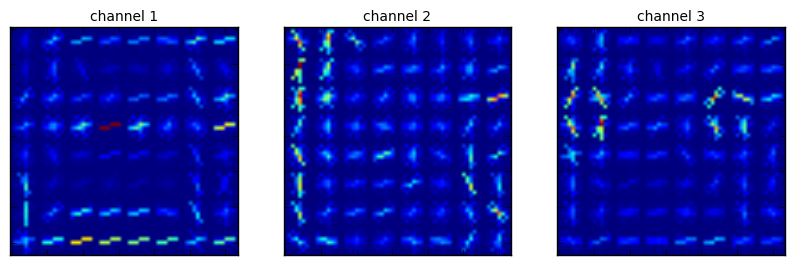

In [4]:
from skimage.feature import hog
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()

img = cv2.imread('output_images/car.png')
norm_img = img.astype(np.float32)/255.0
feature_image = cv2.cvtColor(norm_img, cv2.COLOR_RGB2YCrCb)
ch = [feature_image[:,:,0], feature_image[:,:,1], feature_image[:,:,2]]

num_channels = 3
f, ax = plt.subplots(1, num_channels, figsize=(10,10))
for idx in range(num_channels):
    features, hog_image = hog(ch[idx], orientations=orient,
                pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block),
                transform_sqrt=True,
                visualise=True, feature_vector=False)
    imgplot = ax[idx].imshow(hog_image)
    ax[idx].set_title("channel {0}".format(idx+1), fontsize=10)
    ax[idx].xaxis.set_major_formatter(nullfmt)
    ax[idx].yaxis.set_major_formatter(nullfmt)
plt.show()

### Extract Car and Non-Car Features

In [ ]:
car_features = []
for car_list, car_directory in zip(cars, car_directories):
    local_car_features = fe.extract_features(car_directory, car_list, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    car_features.extend(local_car_features)

noncar_features = []
for noncar_list, noncar_directory in zip(non_vehicles, noncar_directories):
    local_noncar_features = fe.extract_features(noncar_directory, noncar_list, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    noncar_features.extend(local_noncar_features)

### Train Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = SVC()

# Check the training time for the SVC
startTime=time.time()
svc.fit(X_train, y_train)
endTime = time.time()
print("Training Time: ", round(endTime-startTime, 2))
# Check the score of the SVC
print("Test Accuracy: ", round(svc.score(X_test, y_test), 4))

In [ ]:
# Save SVM Model
f = open('model.save', "wb")
s = pickle.dump([X_scaler, svc], f)
f.close()

In [5]:
# Load SVM Model
f = open('model.save', "rb")
X_scaler, svc = pickle.load(f)
f.close()

In [6]:
def process_image(image):
    local_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    on_windows = fe.search_windows(local_image, ystart, ystop, scale, svc, X_scaler, 
                    spatial_size, hist_bins, 
                    orient, pix_per_cell, cell_per_block)   
    heatmap.add_heat(on_windows)
    return heatmap.draw_labeled_bboxes(image)

### Test Images

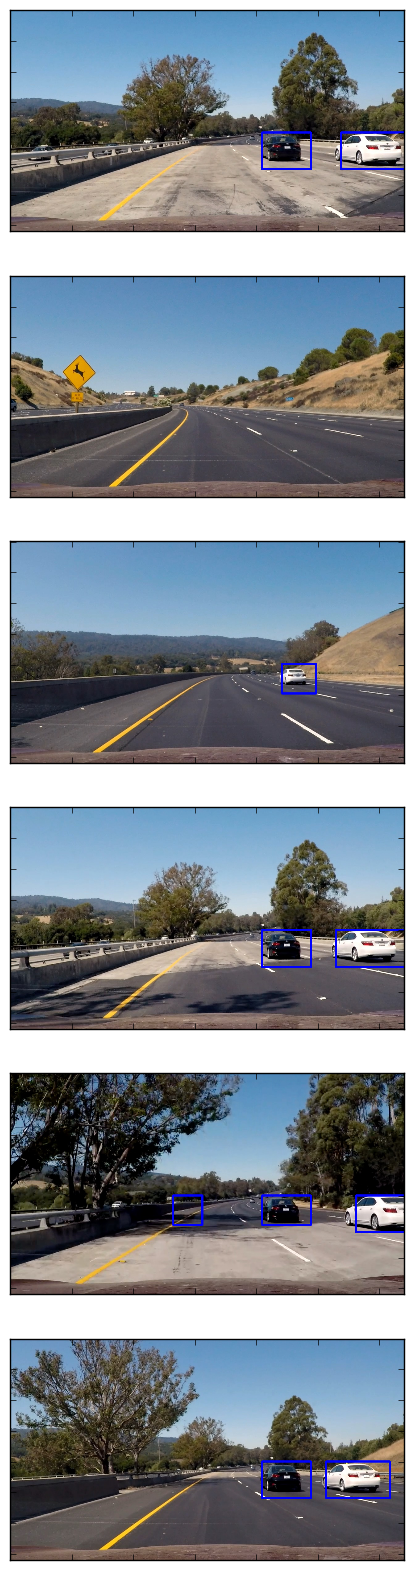

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()

num_images = 6

f, axarr = plt.subplots(num_images, 1, figsize=(20,20))
for idx in range(num_images):
    image = cv2.imread('test_images/test{0}.jpg'.format(idx+1))
    local_heatmap = hm.BoundingBox(image.shape, history_=1, threshold_=1, local_threshold_=1)
    
    on_windows = fe.search_windows(image, ystart, ystop, svc, X_scaler, spatial_size, hist_bins, 
                    orient, pix_per_cell, cell_per_block)
    
    draw_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    local_heatmap.add(on_windows)
    result_image = local_heatmap.draw_labeled_bboxes(draw_image)
    #result_image = util.draw_boxes(draw_image, on_windows)
               
    imgplot = axarr[idx].imshow(result_image)
    #plt.colorbar(imgplot, ax=axarr)
    axarr[idx].xaxis.set_major_formatter(nullfmt)
    axarr[idx].yaxis.set_major_formatter(nullfmt)
plt.show()

### Video Test

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
output_video = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
heatmap = hm.BoundingBox(img_shape)
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(output_video, audio=False)